In [1]:
cd ..

d:\research\fedmiss_bench


In [122]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from src.loaders.load_data import load_data
from src.loaders.load_data_partition import load_data_partition, separate_data
from src.modules.missing_simulate.mcar_simulate import simulate_nan_mcar
from src.modules.missing_simulate.mar_simulate import simulate_nan_mar_sigmoid, simulate_nan_mar_quantile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [150]:
train_data, test_data, config = load_data('codon', test_size=0.1)
train_data = pd.DataFrame(train_data).sample(frac=0.5).values
print(train_data.shape, test_data.shape)

(13008, 26)
(5854, 26) (1301, 26)


In [156]:
X, y, stats = separate_data(
    train_data, num_clients = 10, niid = True, alpha = 0.05, least_samples = 50, local_test_ratio=0
)

Client data size does not meet the minimum requirement 50. Try allocating again for the 2-th time.
Client data size does not meet the minimum requirement 50. Try allocating again for the 3-th time.
Client data size does not meet the minimum requirement 50. Try allocating again for the 4-th time.
Client data size does not meet the minimum requirement 50. Try allocating again for the 5-th time.
Client 0	 Size of data: 554	 Labels:  [3. 4. 5. 6. 9.]
		 Samples of labels:  [(3, 1), (4, 316), (5, 23), (6, 213), (9, 1)]
--------------------------------------------------
Client 1	 Size of data: 523	 Labels:  [1. 3. 5. 6. 7.]
		 Samples of labels:  [(1, 47), (3, 2), (5, 4), (6, 386), (7, 84)]
--------------------------------------------------
Client 2	 Size of data: 535	 Labels:  [5.]
		 Samples of labels:  [(5, 535)]
--------------------------------------------------
Client 3	 Size of data: 330	 Labels:  [5. 6. 8. 9.]
		 Samples of labels:  [(5, 4), (6, 233), (8, 92), (9, 1)]
----------------

In [105]:
X_ms = []
for X_origin in X:
    X_ms.append(simulate_nan_mcar(X_origin, cols = np.arange(X_origin.shape[1]), missing_ratio=0.5))

In [157]:
X_ms = []
seeds = 0 
for X_origin in X:
    X_ms.append(
        simulate_nan_mar_sigmoid(
            X_origin, cols = np.arange(X_origin.shape[1] - 3), missing_ratio=0.5, obs = True, strict = True, k = 'all',
            missing_func=str(np.random.choice(['left', 'right']))
        )
    )

In [133]:
class Client:
    def __init__(self, X, X_ms, y):
        self.X = X
        self.y = y
        self.X_ms = X_ms
        self.mask = np.isnan(X_ms)
        self.X_imp = X_ms.copy()
        self.X_imp[self.mask] = 0
        self.imp_model = None

# Model

In [32]:
# stdlib
from typing import Any, List, Dict, Tuple

# third party
import numpy as np
import torch
from torch import nn, optim
import torch.distributions as td

# hyperimpute absolute
from emf.reproduce_utils import set_seed
from src.imputation.models.vae_models.decoder import GaussianDecoder, BernoulliDecoder, StudentTDecoder
from src.imputation.models.vae_models.encoder import BaseEncoder

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def weights_init(layer: Any) -> None:
    if type(layer) == nn.Linear:
        torch.nn.init.orthogonal_(layer.weight)


class MIWAE(nn.Module):
    """MIWAE imputation plugin

    Args:
        n_epochs: int
            Number of training iterations
        batch_size: int
            Batch size
        latent_size: int
            dimension of the latent space
        n_hidden: int
            number of hidden units
        K: int
            number of IS during training
        random_state: int
            random seed

    Reference: "MIWAE: Deep Generative Modelling and Imputation of Incomplete Data", Pierre-Alexandre Mattei,
    Jes Frellsen
    Original code: https://github.com/pamattei/miwae
    """

    def __init__(
            self,
            num_features: int,
            latent_size: int = 1,
            n_hidden: int = 16,
            n_hidden_layers: int = 2,
            seed: int = 0,
            out_dist='studentt',
            K: int = 20,
            L: int = 1000,
    ) -> None:

        super().__init__()
        set_seed(seed)

        # parameters
        self.num_features = num_features
        self.n_hidden = n_hidden  # number of hidden units in (same for all MLPs)
        self.n_hidden_layers = n_hidden_layers  # number of hidden layers in (same for all MLPs)
        self.latent_size = latent_size  # dimension of the latent space
        self.K = K  # number of IS during training
        self.L = L  # number of samples for imputation

        # encoder
        self.encoder = BaseEncoder(
            self.num_features, self.latent_size, [self.n_hidden for _ in range(self.n_hidden_layers)],
        ).to(DEVICE)

        # decoder
        self.out_dist = out_dist
        if out_dist == 'studentt':
            self.decoder = StudentTDecoder(
                self.latent_size, self.num_features, [self.n_hidden for _ in range(self.n_hidden_layers)],
            )
        elif out_dist == 'gaussian':
            self.decoder = GaussianDecoder(
                self.latent_size, self.num_features, [self.n_hidden for _ in range(self.n_hidden_layers)],
            )
        elif out_dist == 'bernoulli':
            self.decoder = BernoulliDecoder(
                self.latent_size, self.num_features, [self.n_hidden for _ in range(self.n_hidden_layers)],
            )
        else:
            raise ValueError("Invalid output distribution")

        self.decoder = self.decoder.to(DEVICE)
        
        # mapping z to mask using hint
        self.mask_net = nn.Sequential(
            nn.Linear(self.latent_size, self.n_hidden),
            nn.ReLU(),
            nn.Linear(self.n_hidden, self.n_hidden),
            nn.ReLU(),
            nn.Linear(self.n_hidden, self.num_features),
            nn.Sigmoid()
        ).to(DEVICE)
        
        self.z_L = None
        self.mask_L = None

        # prior for z
        self.p_z = td.Independent(
            td.Normal(loc=torch.zeros(self.latent_size).to(DEVICE), scale=torch.ones(self.latent_size).to(DEVICE)), 1
        )

    @staticmethod
    def name() -> str:
        return "miwae"

    def init(self, seed):
        set_seed(seed)
        self.encoder.apply(weights_init)
        self.decoder.apply(weights_init)
        self.mask_net.apply(weights_init)

    def compute_loss(self, inputs: List[torch.Tensor]) -> Tuple[torch.Tensor, Dict]:
        x, mask = inputs  # x - data, mask - missing mask
        batch_size = x.shape[0]

        # encoder
        mu, logvar = self.encoder(x)

        q_zgivenxobs = td.Independent(td.Normal(loc=mu, scale=logvar), 1)
        zgivenx = q_zgivenxobs.rsample([self.K])  # shape (K, batch_size, latent_size)
        zgivenx_flat = zgivenx.reshape([self.K * batch_size, self.latent_size])
        
        self.z_L = zgivenx_flat

        # decoder
        out_decoder = self.decoder(zgivenx_flat)
        recon_x_means = self.decoder.l_out_mu(out_decoder)

        # compute loss
        data_flat = torch.Tensor.repeat(x, [self.K, 1]).reshape([-1, 1]).to(DEVICE)
        tiled_mask = torch.Tensor.repeat(mask, [self.K, 1]).to(DEVICE)
        self.mask_L = tiled_mask

        # p(x|z)
        all_log_pxgivenz_flat = self.decoder.dist_xgivenz(out_decoder, flat=True).log_prob(data_flat)
        all_log_pxgivenz = all_log_pxgivenz_flat.reshape([self.K * batch_size, self.num_features])
        logpxobsgivenz = torch.sum(all_log_pxgivenz * tiled_mask, 1).reshape([self.K, batch_size])

        # p(z) and q(z|x)
        logpz = self.p_z.log_prob(zgivenx)
        logq = q_zgivenxobs.log_prob(zgivenx)

        neg_bound = -torch.mean(torch.logsumexp(logpxobsgivenz + logpz - logq, 0))

        return neg_bound, {}
    
    def mask_prediction_loss(self, x, mask):
        
        with torch.no_grad():
            batch_size = x.shape[0]
            mu, logvar = self.encoder(x)
            q_zgivenxobs = td.Independent(td.Normal(loc=mu, scale=logvar), 1)
            zgivenx = q_zgivenxobs.rsample([self.K])  # shape (K, batch_size, latent_size)
            zgivenx_flat = zgivenx.reshape([self.K * batch_size, self.latent_size])
            z = zgivenx_flat
            tiled_mask = torch.Tensor.repeat(mask, [self.K, 1]).to(DEVICE)
            mask = tiled_mask.reshape([-1, self.num_features]).int()
            mask = mask.float()
            #z = torch.cat([z, mask], 1)
        
        mask_pred = self.mask_net(z)
        loss = torch.nn.BCELoss()(mask_pred, mask)  # predict missing prob -> 1
        
        return loss
    
    def mask_prediction(self, x: torch.Tensor, mask: torch.Tensor, K: int = 10):
        
        with torch.no_grad():
            mu, logvar = self.encoder(x)
            q_zgivenxobs = td.Independent(td.Normal(loc=mu, scale=logvar), 1)
            zgivenx = q_zgivenxobs.rsample([K])  # shape (K, batch_size, latent_size)
            zgivenx_flat = zgivenx.reshape([K * x.shape[0], self.latent_size])
            mask_L = torch.Tensor.repeat(mask, [K, 1])
            #zgivenx_flat = torch.cat([zgivenx_flat, mask_L.reshape([-1, self.num_features]).float()], 1)
            
            mask_pred = self.mask_net(zgivenx_flat)
            mask_pred = mask_pred.reshape([K, x.shape[0], self.num_features])
            
            return mask_pred

    def impute(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        L = self.L
        batch_size = x.shape[0]
        p = x.shape[1]

        # encoder
        self.encoder.to(DEVICE)
        self.decoder.to(DEVICE)
        mu, logvar = self.encoder(x)
        q_zgivenxobs = td.Independent(td.Normal(loc=mu, scale=logvar), 1)

        zgivenx = q_zgivenxobs.rsample([L])
        zgivenx_flat = zgivenx.reshape([L * batch_size, self.latent_size])

        # decoder
        out_decoder = self.decoder(zgivenx_flat)
        recon_x_means = self.decoder.l_out_mu(out_decoder)

        # loss
        data_flat = torch.Tensor.repeat(x, [L, 1]).reshape([-1, 1]).to(DEVICE)
        tiledmask = torch.Tensor.repeat(mask, [L, 1]).to(DEVICE)

        all_log_pxgivenz_flat = self.decoder.dist_xgivenz(out_decoder, flat=True).log_prob(data_flat)
        all_log_pxgivenz = all_log_pxgivenz_flat.reshape([L * batch_size, p])

        logpxobsgivenz = torch.sum(all_log_pxgivenz * tiledmask, 1).reshape([L, batch_size])
        logpz = self.p_z.log_prob(zgivenx)
        logq = q_zgivenxobs.log_prob(zgivenx)

        # imputation weighted samples
        imp_weights = torch.nn.functional.softmax(
            logpxobsgivenz + logpz - logq, 0
        )  # these are w_1,....,w_L for all observations in the batch

        xgivenz = self.decoder.imp_dist_xgivenz(out_decoder)
        xms = xgivenz.sample().reshape([L, batch_size, p])
        xm = torch.einsum("ki,kij->ij", imp_weights, xms)

        # merge imputed values with observed values
        xhat = torch.clone(x)
        xhat[~mask.bool()] = xm[~mask.bool()]

        return xhat


# Federated Learning

In [50]:

from copy import deepcopy
from collections import OrderedDict
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
from src.evaluation.imp_quality_metrics import rmse

def local_train(model, X, mask, train_params, X_true, return_params = False):
    
    model.to(DEVICE)
    lr = train_params['lr']
    weight_decay = train_params['weight_decay']
    epochs = train_params['epochs']
    batch_size = train_params['batch_size']
    verbose = train_params['verbose']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=True)

    # data
    n = X.shape[0]
    X_imp = X.copy()
    X_mask = mask.copy()
    bs = min(batch_size, n)

    final_loss = 0
    rmses = []
    for ep in range(epochs):
        
        # evaluation
        with torch.no_grad():
            X_imp_new = model.impute(
                torch.from_numpy(X_imp).float().to(DEVICE), torch.from_numpy(~X_mask).float().to(DEVICE)
            )
            rmse_value = rmse(X_imp_new.detach().clone().cpu().numpy(), X_true, X_mask)
            rmses.append(rmse_value)

        # shuffle data
        perm = np.random.permutation(n)  # We use the "random reshuffling" version of SGD
        batches_data = np.array_split(X_imp[perm,], int(n / bs), )
        batches_mask = np.array_split(X_mask[perm,], int(n / bs), )
        total_loss, total_iters = 0, 0
        total_mask_loss = 0
        model.train()
        for it in range(len(batches_data)):
            optimizer.zero_grad()
            model.encoder.zero_grad()
            model.decoder.zero_grad()
            model.mask_net.zero_grad()
            b_data = torch.from_numpy(batches_data[it]).float().to(DEVICE)
            b_mask = torch.from_numpy(~batches_mask[it]).float().to(DEVICE)
            data = [b_data, b_mask]
            loss, ret_dict = model.compute_loss(data)

            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_iters += 1


        # print loss
        if (ep + 1) % verbose == 0:
            print('Epoch %s/%s, Loss = %s RMSE = %s' % (ep, epochs, total_loss / total_iters, rmses[-1]))

        if DEVICE == "cuda":
            torch.cuda.empty_cache()
        
        final_loss = total_loss / total_iters

    model.to("cpu")
    
    if return_params:
        return deepcopy(model.state_dict())
    else:
        return model

def impute(model, X, mask):
    model.to(DEVICE)
    X_imp = X.copy()
    X_mask = mask.copy()
    X_imp[mask] = 0
    X_imp = torch.from_numpy(X_imp).float().to(DEVICE)
    X_mask = torch.from_numpy(~X_mask).float().to(DEVICE)
    with torch.no_grad():
        X_imp_new = model.impute(X_imp, X_mask)
    model.to("cpu")
    return X_imp_new.detach().clone().cpu().numpy()


def evaluate_model(clients):
    rmses = []
    for client in clients:
        client.X_imp = impute(client.imp_model, client.X_ms, client.mask)
        rmses.append(rmse(client.X_imp, client.X, client.mask))
    print("RMSE Mean: {:.4f} Std: {:.4f} Max: {:.4f} Min: {:.4f} ".format(
        np.mean(rmses), np.std(rmses), np.max(rmses), np.min(rmses)
    ))
            

## Local

<Axes: >

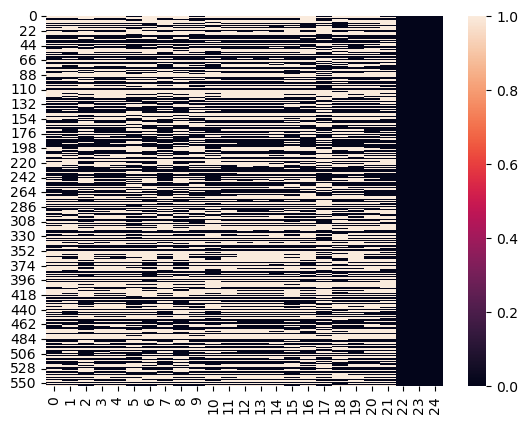

In [165]:
clients = [Client(X[i].copy(), X_ms[i].copy(), y[i].copy()) for i in range(len(X))]
for idx, client in enumerate(clients):
    client.imp_model = MIWAE(
        client.X.shape[1], latent_size=10, n_hidden=32, n_hidden_layers=2, seed=idx, out_dist='gaussian', K=20, L=100, 
    )
    
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(clients[0].mask)

In [166]:
global_iteration = 100

train_params = {
    'lr': 1e-3,
    'weight_decay': 1e-5,
    'epochs': 5,
    'batch_size': 64,
    'verbose': 10
}

for it in range(global_iteration):
    print(f"Global iteration {it}")
    
    # local model training
    params = []
    for client in clients:
        params.append(
            local_train(client.imp_model, client.X_imp, client.mask, train_params, client.X, return_params=True)
        )
    
    fit_res = [{'sample_size': client.X.shape[0]} for client in clients]
    
    # # federated averaging
    # avg_params, _ = fedavg(params, fit_res)
    
    # for idx, client in enumerate(clients):
    #     client.imp_model.load_state_dict(avg_params[idx])
        
    # evaluation
    evaluate_model(clients)

Global iteration 0
RMSE Mean: 0.2131 Std: 0.0616 Max: 0.3263 Min: 0.1110 
Global iteration 1
RMSE Mean: 0.1827 Std: 0.0476 Max: 0.2979 Min: 0.1057 
Global iteration 2
RMSE Mean: 0.1719 Std: 0.0407 Max: 0.2765 Min: 0.1086 
Global iteration 3
RMSE Mean: 0.1653 Std: 0.0360 Max: 0.2555 Min: 0.1048 
Global iteration 4
RMSE Mean: 0.1607 Std: 0.0290 Max: 0.2282 Min: 0.1067 
Global iteration 5
RMSE Mean: 0.1585 Std: 0.0248 Max: 0.2058 Min: 0.1046 
Global iteration 6
RMSE Mean: 0.1564 Std: 0.0225 Max: 0.1906 Min: 0.1020 
Global iteration 7
RMSE Mean: 0.1537 Std: 0.0209 Max: 0.1748 Min: 0.1018 
Global iteration 8
RMSE Mean: 0.1524 Std: 0.0195 Max: 0.1709 Min: 0.1027 
Global iteration 9
RMSE Mean: 0.1509 Std: 0.0189 Max: 0.1702 Min: 0.1027 
Global iteration 10
RMSE Mean: 0.1512 Std: 0.0196 Max: 0.1733 Min: 0.1021 
Global iteration 11
RMSE Mean: 0.1501 Std: 0.0191 Max: 0.1743 Min: 0.1025 
Global iteration 12
RMSE Mean: 0.1506 Std: 0.0184 Max: 0.1732 Min: 0.1038 
Global iteration 13
RMSE Mean: 0.15

## FedAvg Training

In [94]:
def fedavg(local_model_parameters, fit_res):
    # federated averaging implementation
    averaged_model_state_dict = OrderedDict()  # global parameters
    sample_sizes = np.array([item['sample_size'] for item in fit_res])
    normed_weights = sample_sizes / np.sum(sample_sizes)

    for it, local_model_state_dict in enumerate(local_model_parameters):
        for key in local_model_state_dict.keys():
            if it == 0:
                averaged_model_state_dict[key] = normed_weights[it]*local_model_state_dict[key]
            else:
                averaged_model_state_dict[key] += normed_weights[it]*local_model_state_dict[key]

    # copy parameters for each client
    agg_model_parameters = [deepcopy(averaged_model_state_dict) for _ in range(len(local_model_parameters))]
    agg_res = {}

    return agg_model_parameters, agg_res

In [95]:
clients = [Client(X[i].copy(), X_ms[i].copy(), y[i].copy()) for i in range(len(X))]
for idx, client in enumerate(clients):
    client.imp_model = MIWAE(
        client.X.shape[1], latent_size=10, n_hidden=32, n_hidden_layers=2, seed=idx, out_dist='gaussian', K=20, L=100
    )

In [59]:
global_iteration = 50

train_params = {
    'lr': 1e-3,
    'weight_decay': 1e-5,
    'epochs': 5,
    'batch_size': 64,
    'verbose': 10
}

for it in range(global_iteration):
    print(f"Global iteration {it}")
    
    # local model training
    params = []
    for client in clients:
        params.append(
            local_train(client.imp_model, client.X_imp, client.mask, train_params, client.X, return_params=True)
        )
    
    fit_res = [{'sample_size': client.X.shape[0]} for client in clients]
    
    # federated averaging
    avg_params, _ = fedavg(params, fit_res)
    
    for idx, client in enumerate(clients):
        client.imp_model.load_state_dict(avg_params[idx])
        
    # evaluation
    evaluate_model(clients)
    

Global iteration 0
RMSE Mean: 0.2328 Std: 0.0111 Max: 0.2500 Min: 0.2172 
Global iteration 1
RMSE Mean: 0.1556 Std: 0.0151 Max: 0.1827 Min: 0.1364 
Global iteration 2
RMSE Mean: 0.1553 Std: 0.0147 Max: 0.1818 Min: 0.1368 
Global iteration 3
RMSE Mean: 0.1552 Std: 0.0146 Max: 0.1822 Min: 0.1363 
Global iteration 4
RMSE Mean: 0.1548 Std: 0.0148 Max: 0.1816 Min: 0.1360 
Global iteration 5
RMSE Mean: 0.1549 Std: 0.0148 Max: 0.1816 Min: 0.1362 
Global iteration 6
RMSE Mean: 0.1552 Std: 0.0144 Max: 0.1814 Min: 0.1368 
Global iteration 7
RMSE Mean: 0.1555 Std: 0.0141 Max: 0.1814 Min: 0.1367 
Global iteration 8
RMSE Mean: 0.1548 Std: 0.0146 Max: 0.1812 Min: 0.1363 
Global iteration 9
RMSE Mean: 0.1552 Std: 0.0143 Max: 0.1793 Min: 0.1367 
Global iteration 10
RMSE Mean: 0.1552 Std: 0.0144 Max: 0.1799 Min: 0.1364 
Global iteration 11
RMSE Mean: 0.1558 Std: 0.0145 Max: 0.1793 Min: 0.1374 
Global iteration 12
RMSE Mean: 0.1558 Std: 0.0146 Max: 0.1803 Min: 0.1369 
Global iteration 13
RMSE Mean: 0.15

## FedAvg FT

In [162]:
clients = [Client(X[i].copy(), X_ms[i].copy(), y[i].copy()) for i in range(len(X))]
for idx, client in enumerate(clients):
    client.imp_model = MIWAE(
        client.X.shape[1], latent_size=10, n_hidden=32, n_hidden_layers=2, seed=idx, out_dist='gaussian', K=20, L=100
    )

In [163]:
global_iteration = 60
num_ft_steps = 40

train_params = {
    'lr': 1e-3,
    'weight_decay': 1e-5,
    'epochs': 5,
    'batch_size': 64,
    'verbose': 10
}

for it in range(global_iteration):
    print(f"Global iteration {it}")
    
    # local model training
    params = []
    for client in clients:
        params.append(
            local_train(client.imp_model, client.X_imp, client.mask, train_params, client.X, return_params=True)
        )
    
    fit_res = [{'sample_size': client.X.shape[0]} for client in clients]
    
    # federated averaging
    avg_params, _ = fedavg(params, fit_res)
    
    for idx, client in enumerate(clients):
        client.imp_model.load_state_dict(avg_params[idx])
        
    # evaluation
    evaluate_model(clients)

for it in range(num_ft_steps):
    print(f"Fine-tuning step {it}")
    
    # local model training
    params = []
    for client in clients:
        params.append(
            local_train(client.imp_model, client.X_imp, client.mask, train_params, client.X, return_params=True)
        )
        
    # evaluation
    evaluate_model(clients)

Global iteration 0
RMSE Mean: 0.2570 Std: 0.0159 Max: 0.2834 Min: 0.2242 
Global iteration 1
RMSE Mean: 0.1726 Std: 0.0207 Max: 0.1984 Min: 0.1219 
Global iteration 2
RMSE Mean: 0.1708 Std: 0.0211 Max: 0.1973 Min: 0.1200 
Global iteration 3
RMSE Mean: 0.1713 Std: 0.0214 Max: 0.1980 Min: 0.1187 
Global iteration 4
RMSE Mean: 0.1714 Std: 0.0221 Max: 0.1976 Min: 0.1177 
Global iteration 5
RMSE Mean: 0.1715 Std: 0.0222 Max: 0.1992 Min: 0.1175 
Global iteration 6
RMSE Mean: 0.1717 Std: 0.0222 Max: 0.1985 Min: 0.1175 
Global iteration 7
RMSE Mean: 0.1716 Std: 0.0219 Max: 0.1978 Min: 0.1184 
Global iteration 8
RMSE Mean: 0.1722 Std: 0.0227 Max: 0.2001 Min: 0.1176 
Global iteration 9
RMSE Mean: 0.1732 Std: 0.0237 Max: 0.2028 Min: 0.1163 
Global iteration 10
RMSE Mean: 0.1733 Std: 0.0235 Max: 0.2027 Min: 0.1172 
Global iteration 11
RMSE Mean: 0.1742 Std: 0.0240 Max: 0.2043 Min: 0.1171 
Global iteration 12
RMSE Mean: 0.1747 Std: 0.0245 Max: 0.2055 Min: 0.1164 
Global iteration 13
RMSE Mean: 0.17

## FedProx and FT

In [146]:
from torch.optim import Optimizer
import copy

class FedProxOptimizer(Optimizer):
    def __init__(self, params, lr=0.01, lamda=0.1, mu=0.001):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        defaults=dict(lr=lr, lamda=lamda, mu=mu)
        super(FedProxOptimizer, self).__init__(params, defaults)

    def step(self, vstar, closure=None):
        loss=None
        if closure is not None:
            loss=closure
        for group in self.param_groups:
            for p, pstar in zip(group['params'], vstar):
                # w <=== w - lr * ( w'  + lambda * (w - w* ) + mu * w )
                p.data=p.data - group['lr'] * (
                            p.grad.data + group['lamda'] * (p.data - pstar.data.clone()) + group['mu'] * p.data)
        return group['params'], loss

def local_train_prox(model, X, mask, train_params, X_true, return_params = False, mu = 0.001):
    
    global_model = MIWAE(
        X.shape[1], latent_size=10, n_hidden=32, n_hidden_layers=2, seed=0, out_dist='gaussian', K=20, L=100
    )
    global_model.load_state_dict(copy.deepcopy(model.state_dict()))
    model.to(DEVICE)
    global_model.to(DEVICE)
    lr = train_params['lr']
    weight_decay = train_params['weight_decay']
    epochs = train_params['epochs']
    batch_size = train_params['batch_size']
    verbose = train_params['verbose']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=True)

    # data
    n = X.shape[0]
    X_imp = X.copy()
    X_mask = mask.copy()
    bs = min(batch_size, n)

    final_loss = 0
    rmses = []
    for ep in range(epochs):
        
        # evaluation
        with torch.no_grad():
            X_imp_new = model.impute(
                torch.from_numpy(X_imp).float().to(DEVICE), torch.from_numpy(~X_mask).float().to(DEVICE)
            )
            rmse_value = rmse(X_imp_new.detach().clone().cpu().numpy(), X_true, X_mask)
            rmses.append(rmse_value)

        # shuffle data
        perm = np.random.permutation(n)  # We use the "random reshuffling" version of SGD
        batches_data = np.array_split(X_imp[perm,], int(n / bs), )
        batches_mask = np.array_split(X_mask[perm,], int(n / bs), )
        total_loss, total_iters = 0, 0
        total_mask_loss = 0
        model.train()
        for it in range(len(batches_data)):
            optimizer.zero_grad()
            model.encoder.zero_grad()
            model.decoder.zero_grad()
            model.mask_net.zero_grad()
            b_data = torch.from_numpy(batches_data[it]).float().to(DEVICE)
            b_mask = torch.from_numpy(~batches_mask[it]).float().to(DEVICE)
            data = [b_data, b_mask]
            loss, ret_dict = model.compute_loss(data)
            proximal_term = 0.0
            for w, w_t in zip(model.parameters(), global_model.parameters()):
                proximal_term += (w - w_t).norm(2)
            loss = loss + (mu / 2) * proximal_term
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_iters += 1


        # print loss
        if (ep + 1) % verbose == 0:
            print('Epoch %s/%s, Loss = %s RMSE = %s' % (ep, epochs, total_loss / total_iters, rmses[-1]))

        if DEVICE == "cuda":
            torch.cuda.empty_cache()
        
        final_loss = total_loss / total_iters

    model.to("cpu")
    global_model.to("cpu")
    del global_model
    
    if return_params:
        return deepcopy(model.state_dict())
    else:
        return model

In [167]:
clients = [Client(X[i].copy(), X_ms[i].copy(), y[i].copy()) for i in range(len(X))]
for idx, client in enumerate(clients):
    client.imp_model = MIWAE(
        client.X.shape[1], latent_size=10, n_hidden=32, n_hidden_layers=2, seed=idx, out_dist='gaussian', K=20, L=100
    )

In [168]:
global_iteration = 50
num_ft_steps = 50

train_params = {
    'lr': 1e-3,
    'weight_decay': 1e-5,
    'epochs': 5,
    'batch_size': 64,
    'verbose': 10
}

for it in range(global_iteration):
    print(f"Global iteration {it}")
    
    # local model training
    params = []
    for client in clients:
        params.append(
            local_train_prox(client.imp_model, client.X_imp, client.mask, train_params, client.X, return_params=True)
        )
    
    fit_res = [{'sample_size': client.X.shape[0]} for client in clients]
    
    # federated averaging
    avg_params, _ = fedavg(params, fit_res)
    
    for idx, client in enumerate(clients):
        client.imp_model.load_state_dict(avg_params[idx])
        
    # evaluation
    evaluate_model(clients)

for it in range(num_ft_steps):
    print(f"Fine-tuning step {it}")
    
    # local model training
    params = []
    for client in clients:
        params.append(
            local_train(client.imp_model, client.X_imp, client.mask, train_params, client.X, return_params=True)
        )
        
    # evaluation
    evaluate_model(clients)

Global iteration 0
RMSE Mean: 0.2542 Std: 0.0170 Max: 0.2805 Min: 0.2212 
Global iteration 1
RMSE Mean: 0.1721 Std: 0.0200 Max: 0.1966 Min: 0.1232 
Global iteration 2
RMSE Mean: 0.1715 Std: 0.0208 Max: 0.1967 Min: 0.1205 
Global iteration 3
RMSE Mean: 0.1711 Std: 0.0211 Max: 0.1968 Min: 0.1196 
Global iteration 4
RMSE Mean: 0.1712 Std: 0.0219 Max: 0.1979 Min: 0.1183 
Global iteration 5
RMSE Mean: 0.1714 Std: 0.0221 Max: 0.1986 Min: 0.1181 
Global iteration 6
RMSE Mean: 0.1715 Std: 0.0219 Max: 0.1982 Min: 0.1185 
Global iteration 7
RMSE Mean: 0.1719 Std: 0.0221 Max: 0.1989 Min: 0.1186 
Global iteration 8
RMSE Mean: 0.1724 Std: 0.0226 Max: 0.2004 Min: 0.1182 
Global iteration 9
RMSE Mean: 0.1731 Std: 0.0233 Max: 0.2023 Min: 0.1175 
Global iteration 10
RMSE Mean: 0.1737 Std: 0.0238 Max: 0.2036 Min: 0.1168 
Global iteration 11
RMSE Mean: 0.1743 Std: 0.0243 Max: 0.2046 Min: 0.1163 
Global iteration 12
RMSE Mean: 0.1750 Std: 0.0249 Max: 0.2058 Min: 0.1156 
Global iteration 13
RMSE Mean: 0.17